# Model Evaluation

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from os import walk
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, precision_recall_curve

In [2]:
def collect_predictions(testset, folder):
    dir_names = next(walk(f"0_resources/3_model_predictions/{folder}"), (None, None, []))[1]
    dir_names.sort()
    for model_name in dir_names:
        testset[model_name] = pd.read_csv(f"0_resources/3_model_predictions/{folder}/{model_name}/test_set_predictions.csv")[model_name]
    return dir_names, testset

In [3]:
def label(predictions, CUTOFF)->[]:
    return [1 if p > CUTOFF else 0 for p in predictions] 

def evaluate(gold_labels, predictions, model_description):
    print("-----------------------------------------------------")
    print(f"Classification report for {model_description}:\n")
    print(classification_report(gold_labels, predictions, digits=4))
    return classification_report(gold_labels, predictions, digits=4, output_dict=True)

def calculate_error_rate(gold_labels, predictions):
    report = classification_report(gold_labels, predictions, digits=4, output_dict=True)
    return (report['accuracy']*100, report['1']['precision']*100, report['1']['recall']*100, report['macro avg']['f1-score']*100)    

In [4]:
def generate_performance_table(performance_scores, models):
    accuracy_scores = [p['accuracy'] for p in performance_scores.values()]
    precision_scores = [p['1']['precision'] for p in performance_scores.values()]
    recall_scores = [p['1']['recall'] for p in performance_scores.values()]
    f1_scores = [p['macro avg']['f1-score'] for p in performance_scores.values()]

    performance_table = pd.DataFrame(
        data = {
            'Model': [m[1] for m in models],
            'Accuracy': accuracy_scores,
            'Precision': precision_scores,
            'Recall': recall_scores,
            'Macro F1': f1_scores
        },
    )
    
    performance_table[["Accuracy","Precision","Recall","Macro F1"]] = (100 * performance_table[["Accuracy","Precision","Recall","Macro F1"]]).round(1).astype(float)
    return performance_table

In [5]:
CUTOFF = 0.5

In [6]:
pd.options.display.float_format = "{:,.1f}".format

## Naive Baselines

In [7]:
import warnings
warnings.filterwarnings('ignore')

testset = pd.read_csv("0_resources/0_dataset/test_split.csv")
testset['max-class'] = [0] * len(testset)
testset['min-class'] = [1] * len(testset)

naive_baselines = [
    ('min-class', 'Min Class Baseline (1)'),
    ('max-class', 'Max Class Baseline (0)'),
]

naive_performance_scores = {}
for model_name, model_description in naive_baselines:
    naive_performance_scores[model_name] = evaluate(testset['label'], testset[model_name], model_description)

-----------------------------------------------------
Classification report for Min Class Baseline (1):

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      2046
           1     0.3180    1.0000    0.4825       954

    accuracy                         0.3180      3000
   macro avg     0.1590    0.5000    0.2413      3000
weighted avg     0.1011    0.3180    0.1535      3000

-----------------------------------------------------
Classification report for Max Class Baseline (0):

              precision    recall  f1-score   support

           0     0.6820    1.0000    0.8109      2046
           1     0.0000    0.0000    0.0000       954

    accuracy                         0.6820      3000
   macro avg     0.3410    0.5000    0.4055      3000
weighted avg     0.4651    0.6820    0.5531      3000



In [8]:
performance_table = generate_performance_table(naive_performance_scores, naive_baselines)

In [9]:
random_performance_scores = []

for i in range(1000):
    predictions = np.random.randint(2, size=len(testset))
    random_performance_scores.append(calculate_error_rate(testset['label'], predictions))

In [10]:
random_performance_scores = np.transpose(np.asarray(random_performance_scores))
performance_table.loc[len(performance_table.index)] = [
    'Random Baseline',
    np.mean(random_performance_scores[0]),
    np.mean(random_performance_scores[1]),
    np.mean(random_performance_scores[2]),
    np.mean(random_performance_scores[3])
]

In [11]:
performance_table

,Model,Accuracy,Precision,Recall,Macro F1
0,Min Class Baseline (1),31.8,31.8,100.0,24.1
1,Max Class Baseline (0),68.2,0.0,0.0,40.5
2,Random Baseline,50.0,31.8,50.0,48.3


## Baseline Models

In [12]:
model_predictions = pd.read_csv("0_resources/0_dataset/test_split.csv")
model_names, model_predictions = collect_predictions(model_predictions, 'baselines')

In [13]:
baseline_models = [
    ('deberta-v3-base', 'DeBERTa Base'),
    ('bert-base-multilingual-uncased', 'mBERT Base'),
    ('xlm-roberta-base', 'XLM RoBERTa Base'),
    ('twitter-xlm-roberta-base',  'Twitter XLM RoBERTa Base'),
    ('indobert-base-uncased', 'IndoBERT Base'),
    ('indobertweet-base-uncased', 'IndoBERTweet Base'),
]

In [14]:
performance_scores = {}
for model_name, model_description in baseline_models:
    predictions = label(model_predictions[model_name], CUTOFF)
    performance_scores[model_name] = evaluate(model_predictions['label'], predictions, model_description)

-----------------------------------------------------
Classification report for DeBERTa Base:

              precision    recall  f1-score   support

           0     0.7956    0.9150    0.8511      2046
           1     0.7311    0.4958    0.5909       954

    accuracy                         0.7817      3000
   macro avg     0.7633    0.7054    0.7210      3000
weighted avg     0.7751    0.7817    0.7684      3000

-----------------------------------------------------
Classification report for mBERT Base:

              precision    recall  f1-score   support

           0     0.8126    0.8309    0.8217      2046
           1     0.6189    0.5891    0.6037       954

    accuracy                         0.7540      3000
   macro avg     0.7158    0.7100    0.7127      3000
weighted avg     0.7510    0.7540    0.7523      3000

-----------------------------------------------------
Classification report for XLM RoBERTa Base:

              precision    recall  f1-score   support

    

In [15]:
generate_performance_table(performance_scores, baseline_models)

,Model,Accuracy,Precision,Recall,Macro F1
0,DeBERTa Base,78.2,73.1,49.6,72.1
1,mBERT Base,75.4,61.9,58.9,71.3
2,XLM RoBERTa Base,78.6,65.8,68.2,75.6
3,Twitter XLM RoBERTa Base,81.0,71.0,68.0,77.8
4,IndoBERT Base,77.8,65.4,64.0,74.3
5,IndoBERTweet Base,82.2,73.8,68.2,79.0


In [16]:
accuracy_scores = [p['accuracy'] for p in performance_scores.values()]
precision_scores = [p['1']['precision'] for p in performance_scores.values()]
recall_scores = [p['1']['recall'] for p in performance_scores.values()]
f1_scores = [p['macro avg']['f1-score'] for p in performance_scores.values()]

## Visualisation

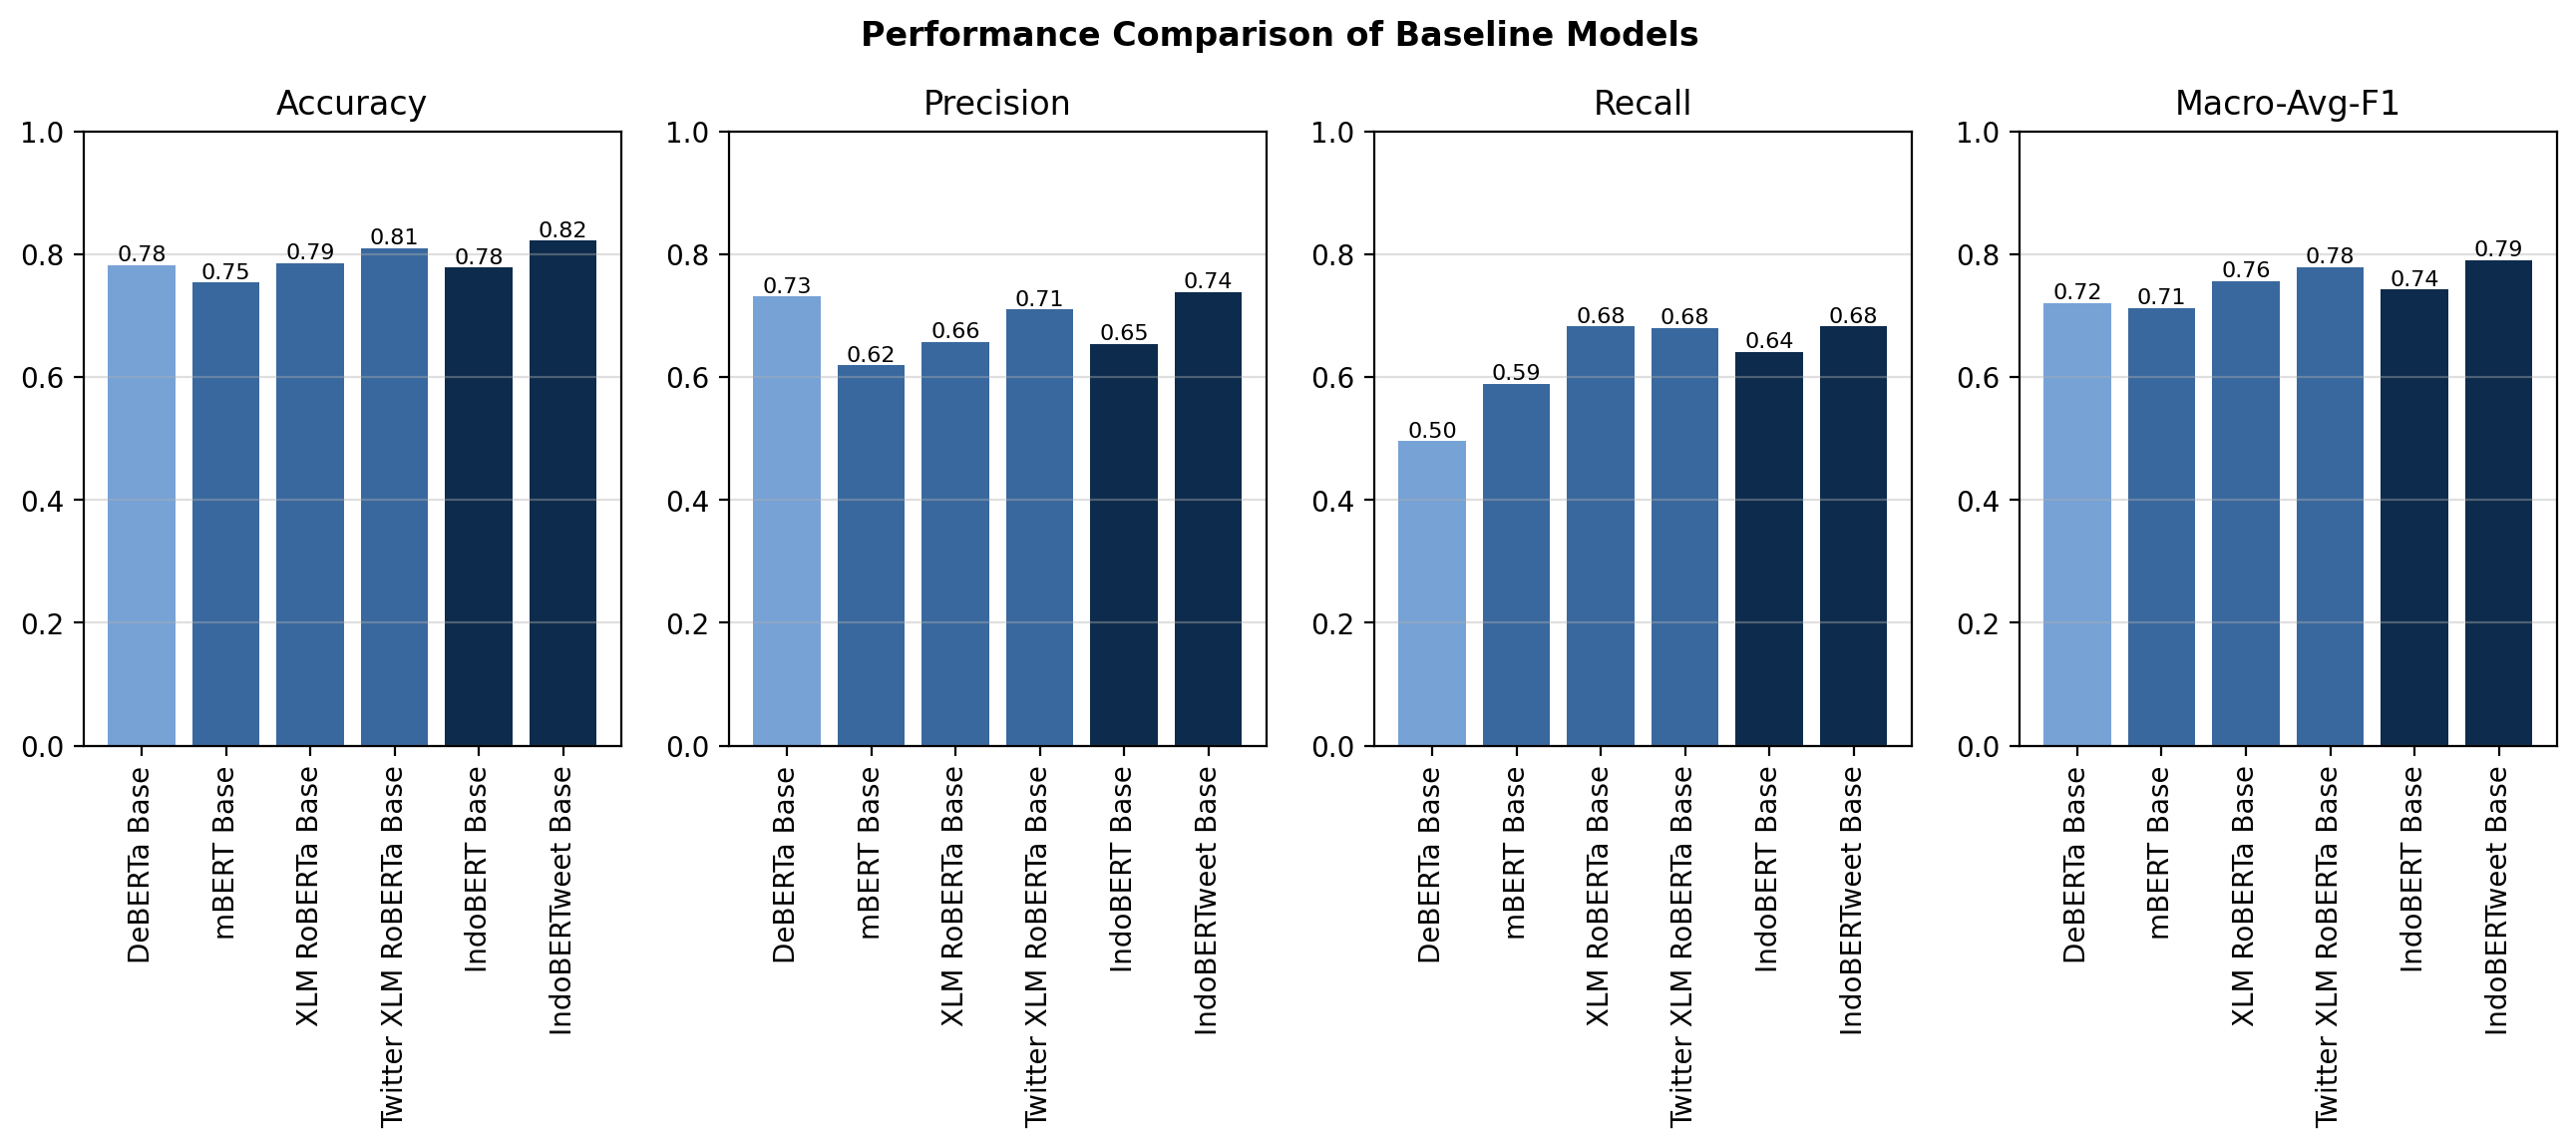

In [17]:
colors = ['#77A2D6', '#39689E', '#39689E', '#39689E', '#0D2B4C', '#0D2B4C']
fig, ax = plt.subplots(1, 4, figsize=(16, 4), dpi=200)

x_labels = [m[1] for m in baseline_models]

for i, title in enumerate(['Accuracy', 'Precision', 'Recall', 'Macro-Avg-F1']):
    ax[i].set_title(title) # Title
    ax[i].set_ylim(0, 1) # Set y axis limits to 0 and 1
    for tick in ax[i].get_xticklabels(): # Rotate x-tick labels
        tick.set_rotation(90)

for i, dict_ in enumerate([accuracy_scores, precision_scores, recall_scores, f1_scores]):
    bars = ax[i].bar(x_labels, dict_, color=colors) 
    ax[i].bar_label(bars, fmt='%.2f', fontsize=8) 
    ax[i].grid(visible=True, which='major', axis='y', alpha=0.4)

_ = plt.suptitle('Performance Comparison of Baseline Models', y=1.02, fontweight='bold')
plt.show()

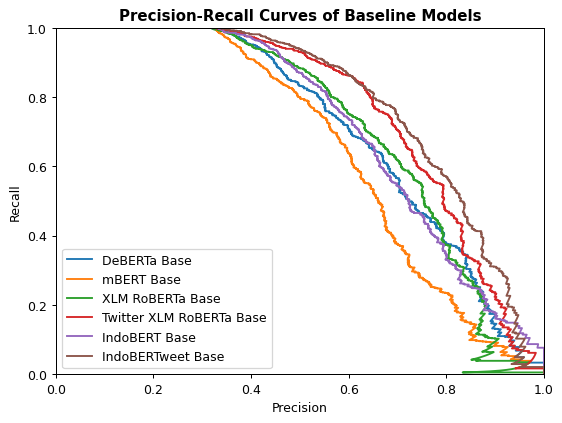

In [18]:
pr_curves = {}
for model_name, model_description in baseline_models:
    predictions = model_predictions[model_name]
    pr_curves[model_description] = precision_recall_curve(model_predictions['label'], predictions)
    
fig, ax = plt.subplots(figsize=(7,5), dpi=90)

for model, p_r_t_arr in pr_curves.items():
    precision_values = p_r_t_arr[0]
    recall_values = p_r_t_arr[1]
    thresholds = p_r_t_arr[2]
    ax.plot(precision_values, recall_values, label=model)
    
plt.xlim(0, 1)
plt.xlabel('Precision')
plt.ylim(0, 1)
plt.ylabel('Recall')
plt.title('Precision-Recall Curves of Baseline Models', fontweight='bold')
plt.legend()
plt.show()

## Experimental Models

### XLMR Domain Adaptaion (Extended Pre-training)

In [19]:
model_names, model_predictions = collect_predictions(model_predictions, 'extended_pretraining')

extended_pretraining_models = [
    ('bert-base-multilingual-uncased', 'mBERT Baseline'),
    ('mbert_100000', 'mBERT + 100k'),
    ('indobert-base-uncased', 'IndoBERT Baseline'),
    ('indobert_100000', 'IndoBERT + 100k'),
    ('indobertweet-base-uncased', 'IndoBERTweet Baseline'),
    ('indobertweet_100000', 'IndoBERTweet + 100k'),
    ('xlm-roberta-base', 'XLMR Baseline'),
    ('xlmr_100000', 'XLMR + 100k'),
    ('twitter-xlm-roberta-base', 'XLMT Baseline'),
    ('xlmt_100000', 'XLMT + 100k'), 
]

In [20]:
extended_pretraining_performance_scores = {}
for model_name, model_description in extended_pretraining_models:
    predictions = label(model_predictions[model_name], CUTOFF)
    extended_pretraining_performance_scores[model_name] = evaluate(model_predictions['label'], predictions, model_description)

-----------------------------------------------------
Classification report for mBERT Baseline:

              precision    recall  f1-score   support

           0     0.8126    0.8309    0.8217      2046
           1     0.6189    0.5891    0.6037       954

    accuracy                         0.7540      3000
   macro avg     0.7158    0.7100    0.7127      3000
weighted avg     0.7510    0.7540    0.7523      3000

-----------------------------------------------------
Classification report for mBERT + 100k:

              precision    recall  f1-score   support

           0     0.8273    0.8543    0.8406      2046
           1     0.6640    0.6174    0.6399       954

    accuracy                         0.7790      3000
   macro avg     0.7456    0.7359    0.7402      3000
weighted avg     0.7754    0.7790    0.7768      3000

-----------------------------------------------------
Classification report for IndoBERT Baseline:

              precision    recall  f1-score   support


In [21]:
performance_table = generate_performance_table(extended_pretraining_performance_scores, extended_pretraining_models)
performance_table

,Model,Accuracy,Precision,Recall,Macro F1
0,mBERT Baseline,75.4,61.9,58.9,71.3
1,mBERT + 100k,77.9,66.4,61.7,74.0
2,IndoBERT Baseline,77.8,65.4,64.0,74.3
3,IndoBERT + 100k,80.6,70.0,68.1,77.5
4,IndoBERTweet Baseline,82.2,73.8,68.2,79.0
5,IndoBERTweet + 100k,83.1,76.3,67.8,79.9
6,XLMR Baseline,78.6,65.8,68.2,75.6
7,XLMR + 100k,80.2,69.5,67.0,76.9
8,XLMT Baseline,81.0,71.0,68.0,77.8
9,XLMT + 100k,81.0,71.8,66.4,77.6


In [22]:
def determine_sign(old, new):
    if new >= old:
        return '+'
    return ''

In [27]:
comparison = []
for i in range(0, int(len(performance_table)), 2):
    b = performance_table.iloc[i]
    p = performance_table.iloc[i+1]
    comparison.append(
        [
            b['Model'].split(" ")[0],
            # f"{p['Accuracy']} ({determine_sign(b['Accuracy'], p['Accuracy'])}{(p['Accuracy'] - b['Accuracy']):.1f})",
            f"{p['Recall']} ({determine_sign(b['Precision'], p['Precision'])}{(p['Precision'] - b['Precision']):.1f})",
            f"{p['Recall']} ({determine_sign(b['Recall'], p['Recall'])}{(p['Recall'] - b['Recall']):.1f})",
            f"{p['Macro F1']} ({determine_sign(b['Macro F1'], p['Macro F1'])}{(p['Macro F1'] - b['Macro F1']):.1f})"
        ]
    )

In [24]:
# for row in comparison:
#     output = ""
#     for entry in row:
#         output += str(entry) + ' & '
#     output = output[:-2] + '\\\\'
#     print(output)

In [25]:
comparison = []
for i in range(0, int(len(performance_table)), 2):
    b = performance_table.iloc[i]
    p = performance_table.iloc[i+1]
    comparison.append([b['Model'].split(" ")[0], b['Macro F1'], p['Macro F1'], f"{determine_sign(b['Macro F1'], p['Macro F1'])}{(p['Macro F1'] - b['Macro F1']):.1f}"])

In [26]:
# for row in comparison:
#     output = ""
#     for entry in row:
#         output += str(entry) + ' & '
#     output = output[:-2] + '\\\\'
#     print(output)